# Лабораторная работа: Прогнозирование временного ряда
Будем использовать датасет **AirPassengers** (кол-во авиапассажиров по месяцам).

**Методы:**
- ARIMA (авторегрессия)
- Символьная регрессия (gplearn)

**Метрики:** MSE, MAE


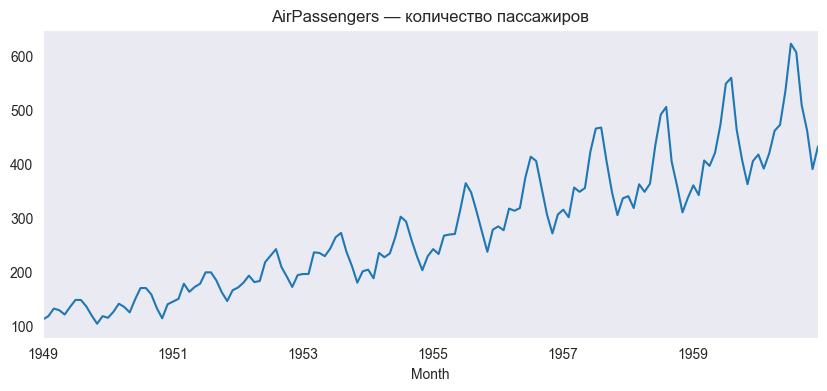

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Загрузка временного ряда
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
series = df['Passengers']
series.plot(title='AirPassengers — количество пассажиров', figsize=(10, 4))
plt.grid()
plt.show()

## Деление на train / test

In [10]:
train = series[:-12]
test = series[-12:]
train.tail(), test.head()

(Month
 1959-08-01    559
 1959-09-01    463
 1959-10-01    407
 1959-11-01    362
 1959-12-01    405
 Name: Passengers, dtype: int64,
 Month
 1960-01-01    417
 1960-02-01    391
 1960-03-01    419
 1960-04-01    461
 1960-05-01    472
 Name: Passengers, dtype: int64)

## Прогноз с использованием ARIMA

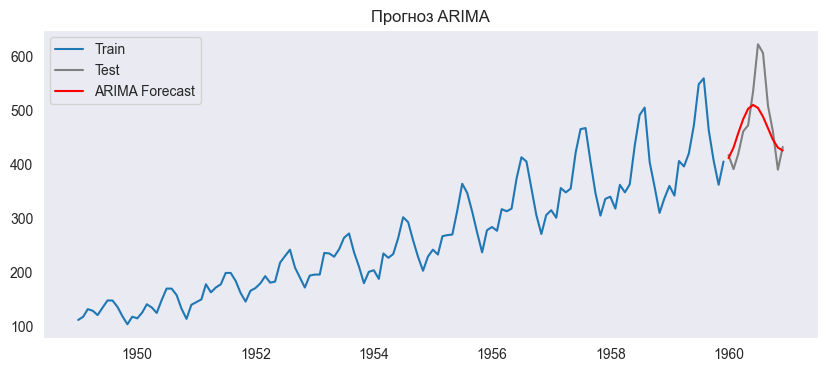

In [11]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(2,1,2))  # можно подобрать через auto_arima
model_fit = model.fit()
forecast_arima = model_fit.forecast(steps=12)

# Визуализация
plt.figure(figsize=(10, 4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='gray')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast', color='red')
plt.title('Прогноз ARIMA')
plt.legend()
plt.grid()
plt.show()

## Прогноз с использованием символьной регрессии

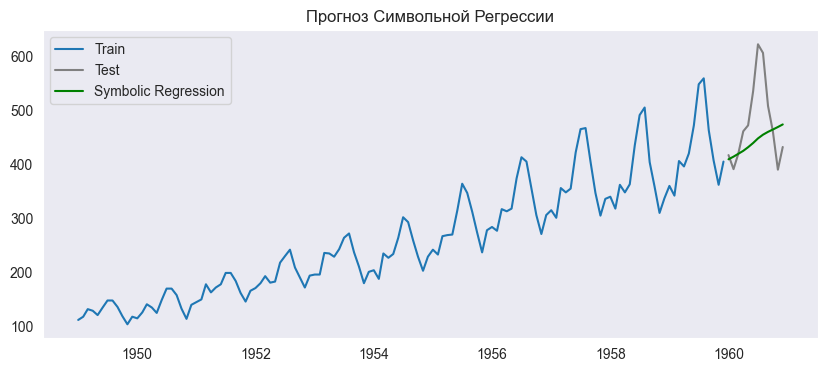

In [12]:
from gplearn.genetic import SymbolicRegressor
import numpy as np

# Подготовим данные: преобразуем временной ряд в supervised формат
def to_supervised(series, lag=12):
    X, y = [], []
    for i in range(len(series) - lag):
        X.append(series[i:i+lag])
        y.append(series[i+lag])
    return np.array(X), np.array(y)

X_train, y_train = to_supervised(train.values)
model_gp = SymbolicRegressor(population_size=500, generations=20, random_state=42)
model_gp.fit(X_train, y_train)

# Прогноз на 12 шагов вперёд
last_values = train.values[-12:].tolist()
forecast_gp = []
for _ in range(12):
    x_input = np.array(last_values[-12:]).reshape(1, -1)
    y_pred = model_gp.predict(x_input)[0]
    forecast_gp.append(y_pred)
    last_values.append(y_pred)

# Визуализация
plt.figure(figsize=(10, 4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='gray')
plt.plot(test.index, forecast_gp, label='Symbolic Regression', color='green')
plt.title('Прогноз Символьной Регрессии')
plt.legend()
plt.grid()
plt.show()

## Оценка качества прогнозов

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('ARIMA:')
print('MSE:', mean_squared_error(test, forecast_arima))
print('MAE:', mean_absolute_error(test, forecast_arima))

print('\nSymbolic Regression:')
print('MSE:', mean_squared_error(test, forecast_gp))
print('MAE:', mean_absolute_error(test, forecast_gp))

ARIMA:
MSE: 3049.5619555805147
MAE: 41.83479826014716

Symbolic Regression:
MSE: 6348.8517137606395
MAE: 58.40480503874346


## Вывод
- ARIMA даёт стабильный прогноз, особенно при наличии тренда.
- Символьная регрессия может уловить нелинейные зависимости, но требует осторожности и тюнинга.
- ARIMA чаще предпочтительнее для временных рядов с сезонностью/трендом.